In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt

In [ ]:
# 1

# Setup
def f(x):
  x_1, x_2 = x[0], x[1]
  return (np.exp(x_1 + 3 * x_2 - 0.1) + np.exp(x_1 - 3 * x_2 - 0.1) + np.exp(-x_1 - 0.1))

def grad_f(x):
  x_1, x_2 = x[0], x[1]
  grad_x_1 = np.exp(x_1 + 3 * x_2 - 0.1) + np.exp(x_1 - 3 * x_2 - 0.1) - np.exp(-x_1 - 0.1)
  grad_x_2 = 3 * np.exp(x_1 + 3 * x_2 - 0.1) - 3 * np.exp(x_1 - 3 * x_2 - 0.1)
  return np.array([grad_x_1, grad_x_2])

def hess_f(x):
  x_1, x_2 = x[0], x[1]
  hess_x_1_x_1 = np.exp(x_1 + 3 * x_2 - 0.1) + np.exp(x_1 - 3 * x_2 - 0.1) + np.exp(-x_1 - 0.1)
  hess_x_1_x_2 = 3 * np.exp(x_1 + 3 * x_2 - 0.1) - 3 * np.exp(x_1 - 3 * x_2 - 0.1)
  hess_x_2_x_1 = 3 * np.exp(x_1 + 3 * x_2 - 0.1) - 3 * np.exp(x_1 - 3 * x_2 - 0.1)
  hess_x_2_x_2 = 9 * np.exp(x_1 + 3 * x_2 - 0.1) + 9 * np.exp(x_1 - 3 * x_2 - 0.1)
  return np.array([
                   [hess_x_1_x_1, hess_x_1_x_2],
                   [hess_x_2_x_1, hess_x_2_x_2]
                   ])

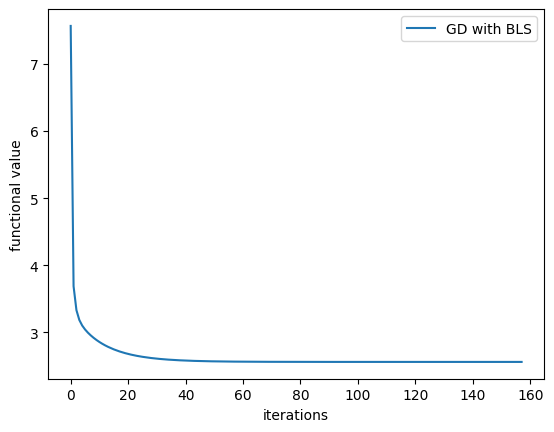

x_optimal: [-3.45840833e-01  7.16698191e-18], function value at x_optimal: 2.559267383735509


In [ ]:
# Gradient descent with backtracking line search

x_init = np.array([0.5, 0.5])
alpha = 1
beta = 0.6
mu = 0.45

max_iters = 1000
tolerance = 1e-9
f_values_gd = np.ones(max_iters)
f_values_gd[0] = f(x_init)

for iteration in range(1, max_iters):
  while f(x_init - alpha * grad_f(x_init)) > f(x_init) - mu * alpha * grad_f(x_init) @ grad_f(x_init):
    alpha = beta * alpha
  x_updated = x_init - alpha * grad_f(x_init)
  f_values_gd[iteration] = f(x_updated)
  if sum((x_updated - x_init)**2) <= tolerance:
    break
  x_init = x_updated
f_values_gd[iteration:] = f(x_init)

x_gd = x_init.copy()

plt.plot(np.arange(0, iteration, 1), f_values_gd[ :iteration], label = 'GD with BLS')
plt.xlabel('iterations')
plt.ylabel('functional value')
plt.legend()
plt.show()

print(f'x_optimal: {x_init}, function value at x_optimal: {f(x_init)}')

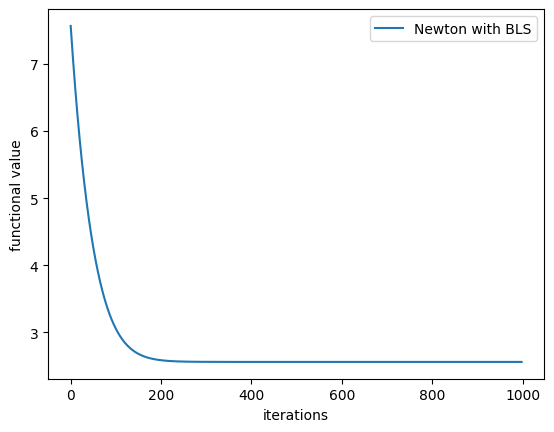

x_optimal: [-3.46573475e-01  7.54127554e-08], function value at x_optimal: 2.5592666966582653


In [ ]:
# Newton's method with backtracking line search

x_init = np.array([0.5, 0.5])
alpha = 1
beta = 0.6
mu = 0.45

max_iters = 1000
tolerance = 1e-9
f_values_n = np.ones(max_iters)
f_values_n[0] = f(x_init)

for iteration in range(1, max_iters):
  while f(x_init - alpha * grad_f(x_init)) > f(x_init) - mu * alpha * grad_f(x_init) @ grad_f(x_init):
    alpha = beta * alpha
  x_updated = x_init - alpha * np.linalg.inv(hess_f(x_init)) @ grad_f(x_init)
  f_values_n[iteration] = f(x_updated)
  if sum((x_updated - x_init)**2)**(0.5) <= tolerance:
    break
  x_init = x_updated
f_values_n[iteration:] = f(x_init)

x_n = x_init.copy()

plt.plot(np.arange(0, iteration, 1), f_values_n[ :iteration], label = 'Newton with BLS')
plt.xlabel('iterations')
plt.ylabel('functional value')
plt.legend()
plt.show()

print(f'x_optimal: {x_init}, function value at x_optimal: {f(x_init)}')

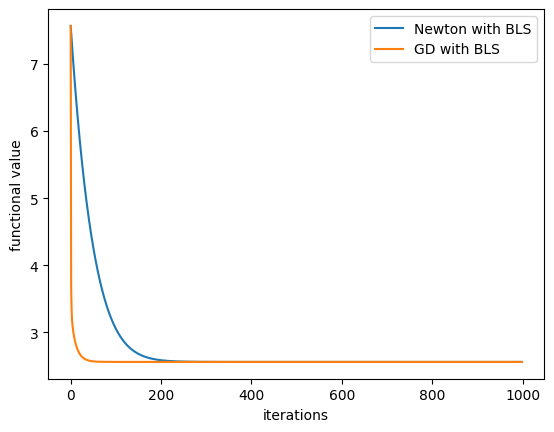

In [ ]:
# Comparison

plt.plot(np.arange(0, iteration, 1), f_values_n[ :iteration], label = 'Newton with BLS')
plt.plot(np.arange(0, iteration, 1), f_values_gd[ :iteration], label = 'GD with BLS')
plt.xlabel('iterations')
plt.ylabel('functional value')
plt.legend()
plt.show()

In [ ]:
# 2

# Setup
emissions = loadmat('emission-1.mat')
p = emissions['p']
y = emissions['y'].flatten()
p_df = pd.DataFrame(p).rename(columns = {0 : 'p_j1', 1 : 'p_j2', 2 : 'p_j3'})
y_df = pd.DataFrame(y).rename(columns = {0 : 'y_j'})
py_df = pd.merge(y_df, p_df, left_index = True, right_index = True)

def logL(mu): # ignoring the factorial term as that is independent of the parameters
  return (y * np.log(p @ mu)).sum(axis = 0) - (mu * p.sum(axis = 0)).sum()

def grad_logL(mu):
  return ((y[:, None] * p[:, :]) / (p @ mu)[:, None]).sum(axis = 0) - np.ones(3)

def hess_logL(mu):
  return  ((-y[:, None, None] * p[:, :, None] * p[:, None, :]) / ((p @ mu)**2)[:, None, None]).sum(axis = 0)

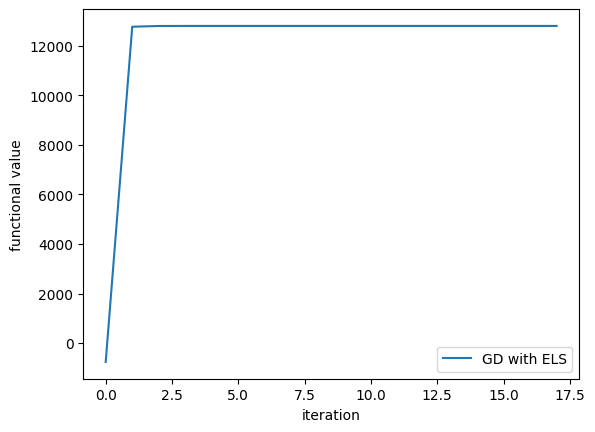

x_optimal: [ 737.64841651  381.79970278 1252.55072645], function value at x_optimal: 12804.155553659073


In [ ]:
# Gradient ascent with exact line search

mu_init = np.array([1, 1, 1])
max_iters = 1000
tolerance = 1e-9
logL_values_gd = np.ones(max_iters)
logL_values_gd[0] = logL(mu_init)

for iteration in range(1, max_iters):
  f_alpha = lambda alpha: -logL(mu_init + alpha * grad_logL(mu_init))  # Minimize the negative of the log-likelihood
  alpha = opt.minimize_scalar(f_alpha).x

  mu_updated = mu_init + alpha * grad_logL(mu_init)
  logL_values_gd[iteration] = logL(mu_updated)
  if sum((mu_updated - mu_init)**2)**(0.5) <= tolerance:
    break
  mu_init = mu_updated
logL_values_gd[iteration:] = logL(mu_init)

mu_gd = mu_init.copy()

plt.plot(np.arange(0, iteration, 1), logL_values_gd[ :iteration], label = 'GD with ELS')
plt.xlabel('iteration')
plt.ylabel('functional value')
plt.legend()
plt.show()

print(f'x_optimal: {mu_init}, function value at x_optimal: {logL(mu_init)}')

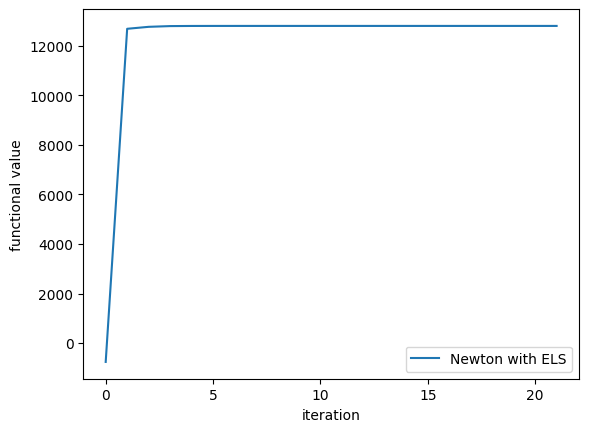

x_optimal: [ 737.64868749  381.79952504 1252.55188764], function value at x_optimal: 12804.155553659357


In [ ]:
# Newton's method with exact line search

mu_init = np.array([1, 1, 1])
max_iters = 1000
tolerance = 1e-9
logL_values_n = np.ones(max_iters)
logL_values_n[0] = logL(mu_init)

for iteration in range(1, max_iters):
  f_alpha = lambda alpha: -logL(mu_init - alpha * np.linalg.inv(hess_logL(mu_init)) @ grad_logL(mu_init))  # Minimize the negative of the log-likelihood
  alpha = opt.minimize_scalar(f_alpha).x

  mu_updated = mu_init - alpha * np.linalg.inv(hess_logL(mu_init)) @ grad_logL(mu_init)
  logL_values_n[iteration] = logL(mu_updated)
  if sum((mu_updated - mu_init)**2)**(0.5) <= tolerance:
    break
  mu_init = mu_updated
logL_values_n[iteration:] = logL(mu_init)

mu_n = mu_init.copy()

plt.plot(np.arange(0, iteration, 1), logL_values_n[ :iteration], label = 'Newton with ELS')
plt.xlabel('iteration')
plt.ylabel('functional value')
plt.legend()
plt.show()

print(f'x_optimal: {mu_init}, function value at x_optimal: {logL(mu_init)}')

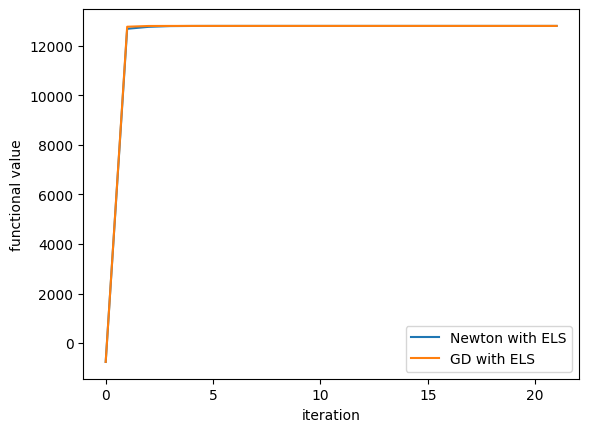

In [ ]:
plt.plot(np.arange(0, iteration, 1), logL_values_n[ :iteration], label = 'Newton with ELS')
plt.plot(np.arange(0, iteration, 1), logL_values_gd[ :iteration], label = 'GD with ELS')
plt.xlabel('iteration')
plt.ylabel('functional value')
plt.legend()
plt.show()

In [ ]:
true_emissions = loadmat('true-1.mat')
mu_true = true_emissions['mu'].reshape(-1)

# Errors
print(f'MSE on mu by GD: {((mu_true - mu_gd)**2).sum()/3}')
print(f'MSE on mu by N: {((mu_true - mu_n)**2).sum()/3} \n')

# Iterations
print(f'Iterations required for convergence in GD: {list(logL_values_gd).index(logL(mu_gd))}')
print(f'Iterations required for convergence in N: {list(logL_values_n).index(logL(mu_n))} \n')

print('The MSE from either method is the same but the gradient method achieves it in fewer iterations.')

MSE on mu by GD: 468.84560029798723
MSE on mu by N: 468.86598354078524 

Iterations required for convergence in GD: 17
Iterations required for convergence in N: 20 

The MSE from either method is the same but the gradient method achieves it in fewer iterations.
